### Pytorch

#### GAN From Scratch


In [3]:
! pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:
import os
import torch
import torchvision
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F  # All functions that don't have any parameters

import torchvision.datasets as datasets  # Has standard datasets we can import in a nice way
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
import torchvision.utils as save_image 

from torch.utils.data import DataLoader, Dataset, random_split  # Gives easier dataset managment and creates mini batches
from torchvision.datasets import MNIST, ImageFolder
from torchvision.utils import make_grid

import pytorch_lightning as pl
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

In [46]:
### parameters

random_seed =42
torch.manual_seed(random_seed)

BATCH_SIZE =128
AVAIL_GPUS =min(1, torch.cuda.device_count())
NUM_WORKERS =int(os.cpu_count()/2)

In [47]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./data", 
                 batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

In [48]:
# Detective: fake or no fake -> 1 output [0, 1]
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # Simple CNN
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)
  
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Flatten the tensor so it can be fed into the FC layers
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)

In [49]:
# Generate Fake Data: output like real data [1, 28, 28] and values -1, 1
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 7*7*64)  # [n, 256, 7, 7]
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2) # [n, 64, 16, 16]
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2) # [n, 16, 34, 34]
        self.conv = nn.Conv2d(16, 1, kernel_size=7)  # [n, 1, 28, 28]
    

    def forward(self, x):
        # Pass latent space input into linear layer and reshape
        x = self.lin1(x)
        x = F.relu(x)
        x = x.view(-1, 64, 7, 7)  #256
        
        # Upsample (transposed conv) 16x16 (64 feature maps)
        x = self.ct1(x)
        x = F.relu(x)
        
        # Upsample to 34x34 (16 feature maps)
        x = self.ct2(x)
        x = F.relu(x)
        
        # Convolution to 28x28 (1 feature map)
        return self.conv(x)

In [50]:
### GAN
class GAN(pl.LightningModule):
  def __init__(self, latent_dim =100, lr =0.0002):
      super().__init__()
      self.save_hyperparameters()

      self.generator =Generator(latent_dim=self.hparams.latent_dim)
      self.discriminator =Discriminator()

      #random noise
      self.validation_z =torch.randn(6, self.hparams.latent_dim)

  def forward(self, z):
    return self.generator(z)

  def adversarial_loss(self, y_hat, y):
    return F.binary_cross_entropy(y_hat, y)

  def training_step(self, batch, batch_idx, optimizer_idx):
    real_imgs , _ =batch

    ## sample noise
    z =torch.randn(real_imgs.shape[0], self.hparams.latent_dim)
    z =z.type_as(real_imgs)

    ## train generator : max log(D(G(z)))
    if optimizer_idx ==0: 
      fake_imgs =self(z)
      y_hat =self.discriminator(fake_imgs)

      y =torch.ones(real_imgs.size(0), 1)
      y =y.type_as(real_imgs)

      g_loss =self.adversarial_loss(y_hat, y)

      log_dict ={"g_loss" : g_loss}
      return {"loss": g_loss, "progress_bar": log_dict, "log": log_dict}
    
    ## train discriminator: max log(D(x) + log (1 -D(G(z))))
    if optimizer_idx ==1:
      # how well can it label as real
      y_hat_real =self.discriminator(real_imgs)
      y_real =torch.ones(real_imgs.size(0), 1)
      y_real =y_real.type_as(real_imgs)

      real_loss =self.adversarial_loss(y_hat_real, y_real)

      # how well can it label as fake
      y_hat_fake =self.discriminator(self(z).detach())

      y_fake =torch.zeros(real_imgs.size(0), 1)
      y_fake =y_fake.type_as(real_imgs)

      fake_loss =self.adversarial_loss(y_hat_fake, y_fake)

      d_loss = (real_loss + fake_loss) /2
      
      log_dict ={"d_loss" : d_loss}
      return {"loss": d_loss, "progress_bar": log_dict, "log": log_dict}


  
  def configure_optimizers(self):
    lr =self.hparams.lr
    opt_g =torch.optim.Adam(self.generator.parameters(), lr=lr)
    opt_d =torch.optim.Adam(self.discriminator.parameters(), lr=lr)

    return [opt_g, opt_d], [] 

  def plot_imgs(self):
    z =self.validation_z.type_as(self.generator.lin1.weight)
    sample_imgs =self(z).cpu()

    print('epoch', self.current_epoch)

    fig =plt.figure()

    for i in range(sample_imgs.size(0)):
      plt.subplot(2,3, i+1)
      plt.tight_layout()

      plt.imshow(sample_imgs.detach()[i, 0, :, :], cmap='gray_r', interpolation='none')
      plt.title('Generated Data')
      plt.xticks([])
      plt.yticks([])
      plt.axis('off')

    plt.show()

  def on_epoch_end(self):
    self.plot_imgs()

In [51]:
dm =MNISTDataModule()
model =GAN()

epoch 0


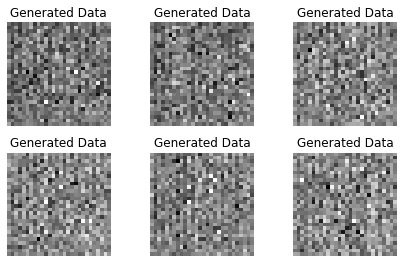

In [52]:
model.plot_imgs()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Missing logger folder: /content/lightning_logs


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 358 K 
1 | discriminator | Discriminator | 21.4 K
------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.520     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

epoch 0


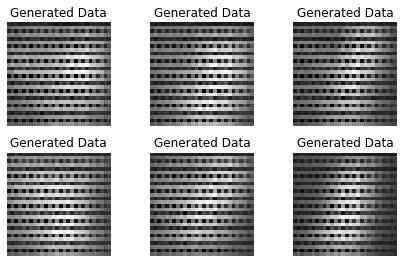

epoch 1


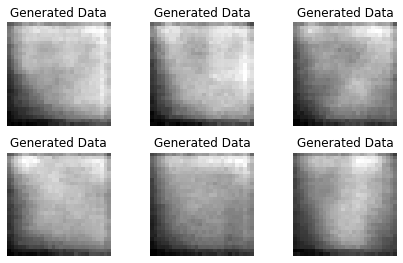

epoch 2


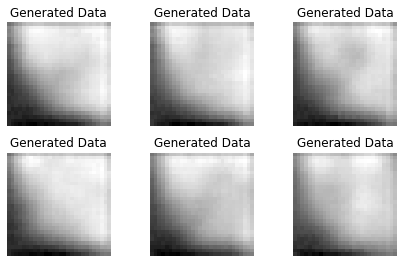

epoch 3


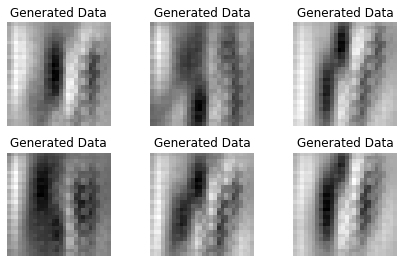

epoch 4


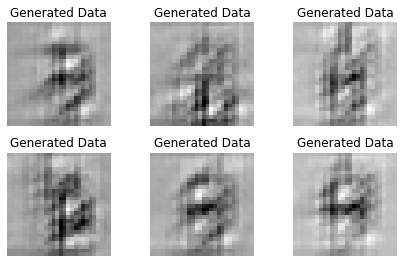

epoch 5


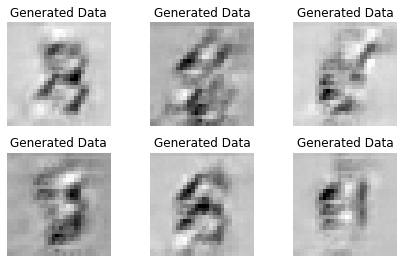

epoch 6


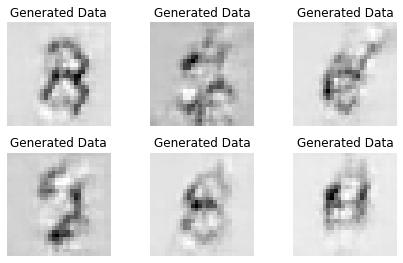

epoch 7


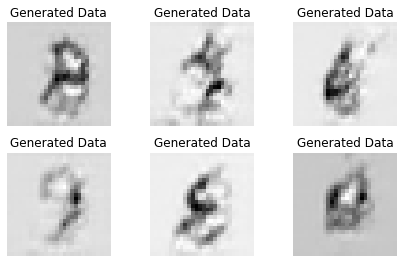

epoch 8


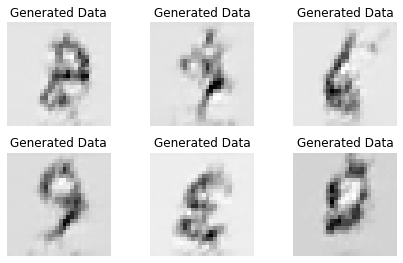

epoch 9


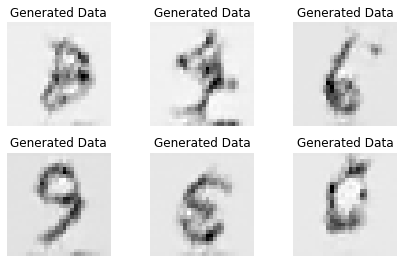

epoch 10


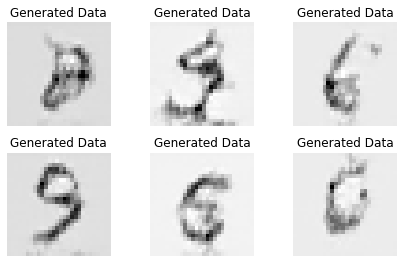

epoch 11


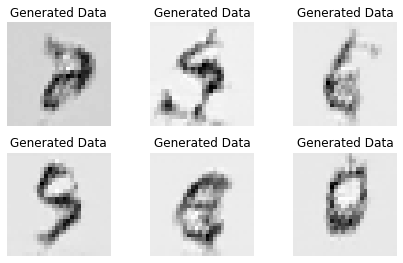

epoch 12


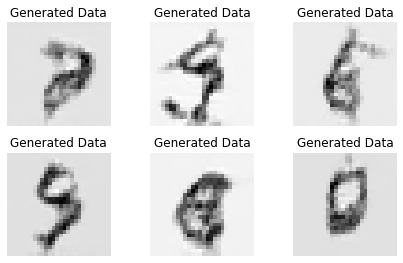

epoch 13


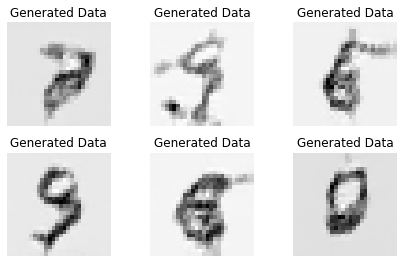

epoch 14


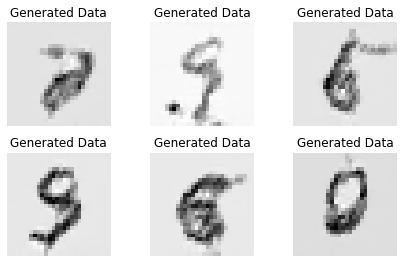

epoch 15


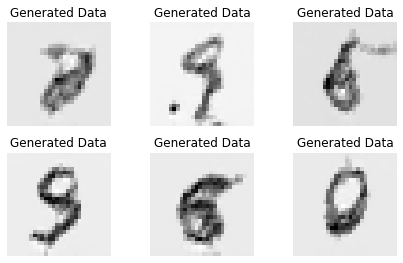

epoch 16


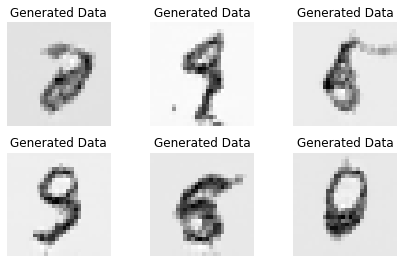

epoch 17


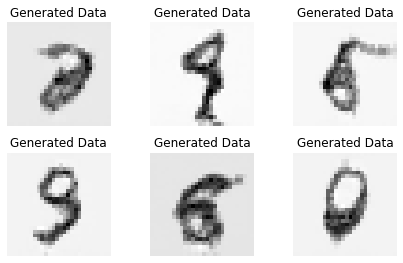

epoch 18


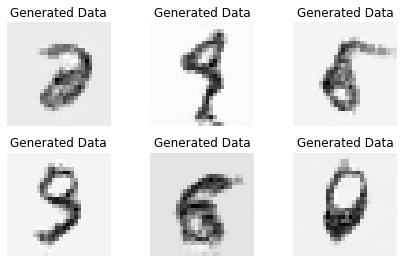

epoch 19


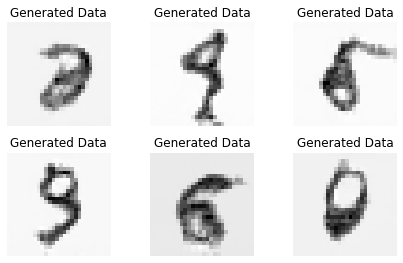

epoch 20


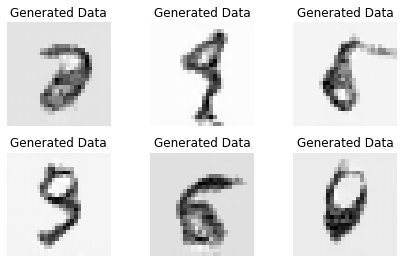

epoch 21


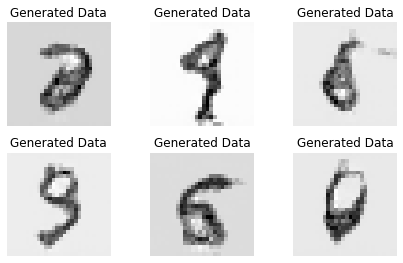

epoch 22


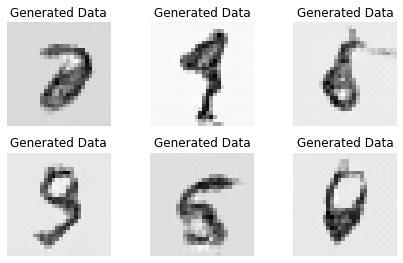

epoch 23


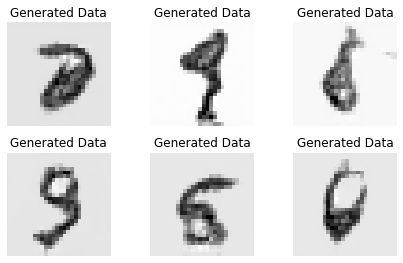

epoch 24


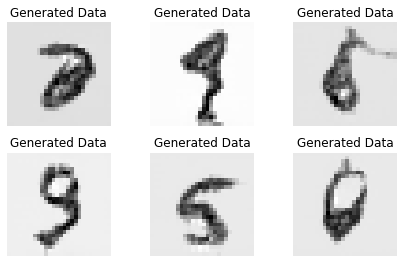

epoch 25


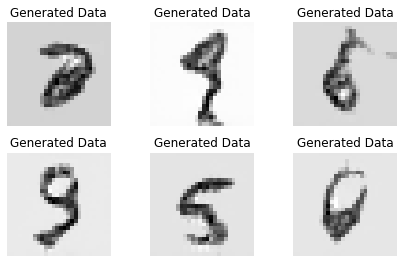

epoch 26


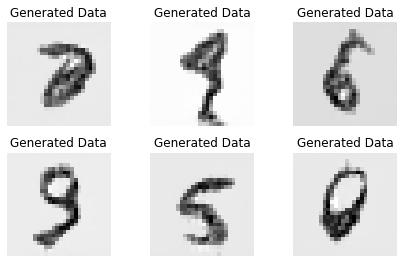

epoch 27


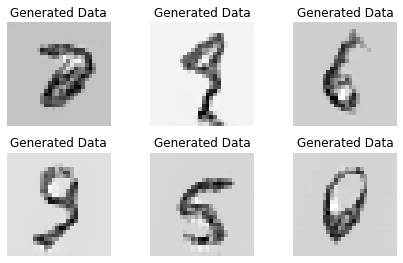

epoch 28


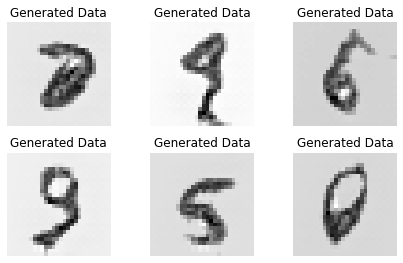

epoch 29


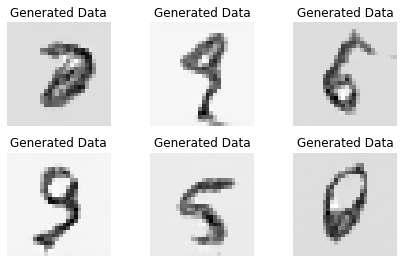

In [53]:
trainer =pl.Trainer(max_epochs=30, gpus =AVAIL_GPUS)
trainer.fit(model, dm)

#### Image Generation using GANs

In [6]:
! pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

100%|██████████| 395M/395M [00:02<00:00, 178MB/s]


In [8]:
import os

DATA_DIR = './animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [9]:
print(os.listdir(DATA_DIR+'/images')[:10])

['40813_2013.jpg', '3145_2002.jpg', '42594_2013.jpg', '11627_2005.jpg', '30093_2010.jpg', '40212_2012.jpg', '24900_2009.jpg', '1883_2001.jpg', '33807_2011.jpg', '14912_2006.jpg']


In [11]:
image_size =64
batch_size =128
stats =(0.5, 0.5, 0.5) , (0.5, 0.5, 0.5)

In [12]:
train_ds =ImageFolder(DATA_DIR, transform =transforms.Compose([transforms.Resize(image_size),
                                                               transforms.CenterCrop(image_size),
                                                               transforms.ToTensor(),
                                                               transforms.Normalize(*stats)]))

train_dl =DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [13]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


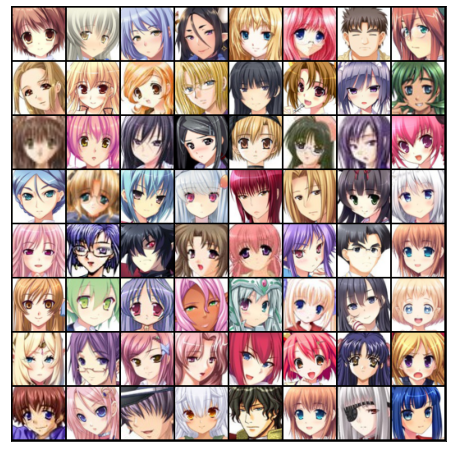

In [14]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break
show_batch(train_dl)

In [15]:
### Using a GPU
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [16]:
device = get_default_device()
device

device(type='cuda')

In [17]:
train_dl = DeviceDataLoader(train_dl, device)

In [18]:
### Discriminator
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

discriminator = to_device(discriminator, device)

In [19]:
### Generator
latent_size = 128
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


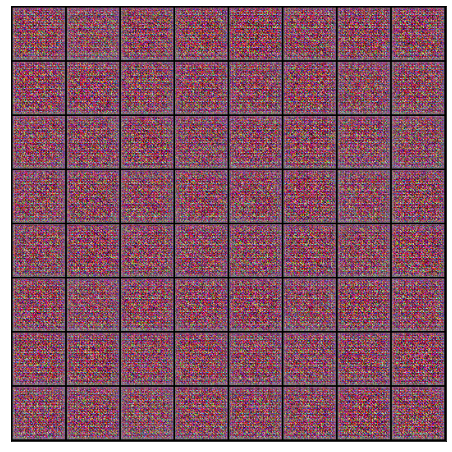

In [20]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [21]:
generator = to_device(generator, device)

In [22]:
### Discriminator Training
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [23]:
### Generator Training
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [24]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [27]:
from torchvision.utils import save_image

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


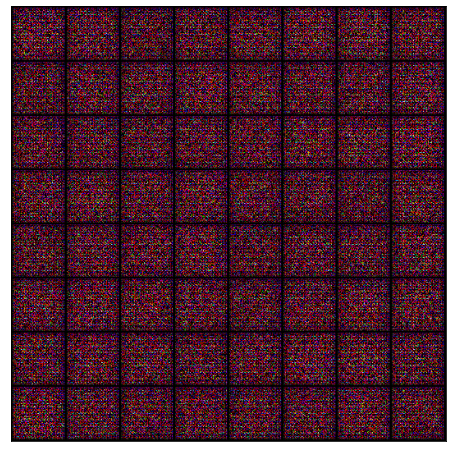

In [31]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

save_samples(0, fixed_latent)

In [32]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [33]:
lr = 0.0002
epochs = 25

history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 6.5742, loss_d: 0.4748, real_score: 0.9025, fake_score: 0.2805
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 5.1644, loss_d: 0.4597, real_score: 0.8611, fake_score: 0.2343
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 5.7192, loss_d: 0.3280, real_score: 0.9235, fake_score: 0.2063
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 4.7762, loss_d: 0.3110, real_score: 0.8395, fake_score: 0.0921
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 4.9911, loss_d: 0.1964, real_score: 0.9510, fake_score: 0.1212
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 4.1193, loss_d: 0.0586, real_score: 0.9606, fake_score: 0.0094
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 7.3001, loss_d: 0.2402, real_score: 0.8239, fake_score: 0.0025
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 7.7194, loss_d: 0.2970, real_score: 0.9566, fake_score: 0.1899
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 3.9813, loss_d: 0.1006, real_score: 0.9467, fake_score: 0.0366
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 5.6736, loss_d: 1.3615, real_score: 0.4057, fake_score: 0.0001
Saving generated-images-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 4.5036, loss_d: 0.2625, real_score: 0.8736, fake_score: 0.0955
Saving generated-images-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 13.2485, loss_d: 1.2987, real_score: 0.9992, fake_score: 0.6202
Saving generated-images-0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 4.5931, loss_d: 0.1038, real_score: 0.9196, fake_score: 0.0122
Saving generated-images-0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 3.7850, loss_d: 0.3449, real_score: 0.7523, fake_score: 0.0106
Saving generated-images-0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 6.4440, loss_d: 0.2583, real_score: 0.9888, fake_score: 0.1961
Saving generated-images-0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 4.0276, loss_d: 0.1614, real_score: 0.9347, fake_score: 0.0744
Saving generated-images-0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 3.8694, loss_d: 0.1559, real_score: 0.9323, fake_score: 0.0736
Saving generated-images-0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 4.9592, loss_d: 0.0909, real_score: 0.9821, fake_score: 0.0667
Saving generated-images-0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 4.0107, loss_d: 0.1549, real_score: 0.9230, fake_score: 0.0641
Saving generated-images-0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 4.3242, loss_d: 0.1951, real_score: 0.8894, fake_score: 0.0614
Saving generated-images-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 3.7852, loss_d: 0.1010, real_score: 0.9457, fake_score: 0.0398
Saving generated-images-0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 2.7572, loss_d: 0.2649, real_score: 0.8352, fake_score: 0.0412
Saving generated-images-0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 4.4317, loss_d: 0.2568, real_score: 0.9574, fake_score: 0.1661
Saving generated-images-0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 5.2747, loss_d: 0.1302, real_score: 0.9660, fake_score: 0.0811
Saving generated-images-0024.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 3.5660, loss_d: 0.1605, real_score: 0.8686, fake_score: 0.0038
Saving generated-images-0025.png


In [34]:
losses_g, losses_d, real_scores, fake_scores = history

# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

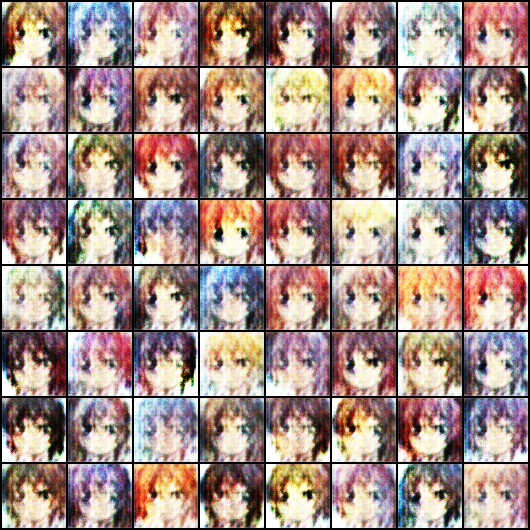

In [35]:
from IPython.display import Image
Image('./generated/generated-images-0001.png')

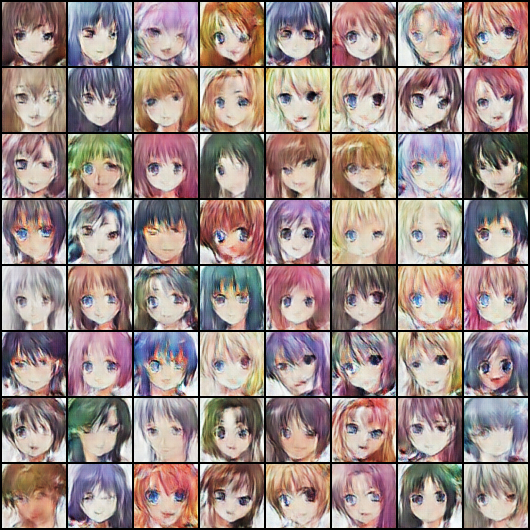

In [36]:
Image('./generated/generated-images-0010.png')

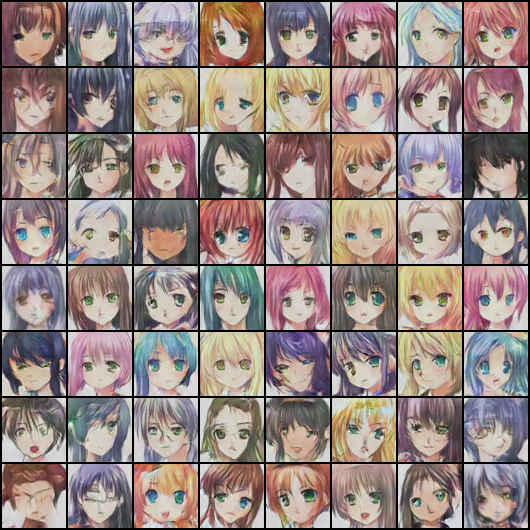

In [37]:
Image('./generated/generated-images-0020.png')

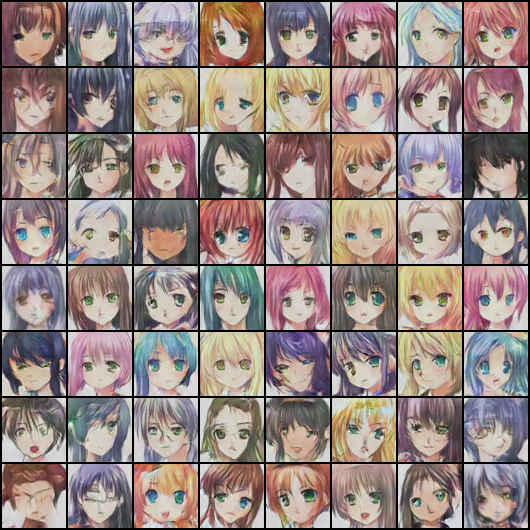

In [42]:
Image('./generated/generated-images-0025.png')

In [39]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

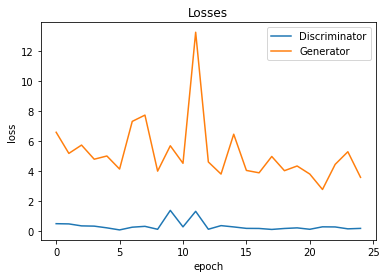

In [40]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

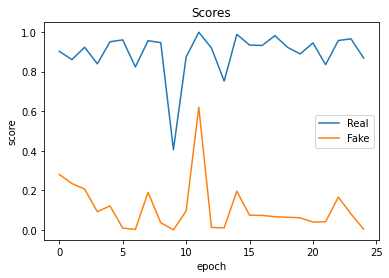

In [41]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

### Tensorflow

#### GAN Fashion mnist

In [112]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np


import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model


import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback


In [113]:
gpus =tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [129]:
ds =tfds.load('fashion_mnist', split='train')
ds.as_numpy_iterator().next().keys()

dict_keys(['image', 'label'])

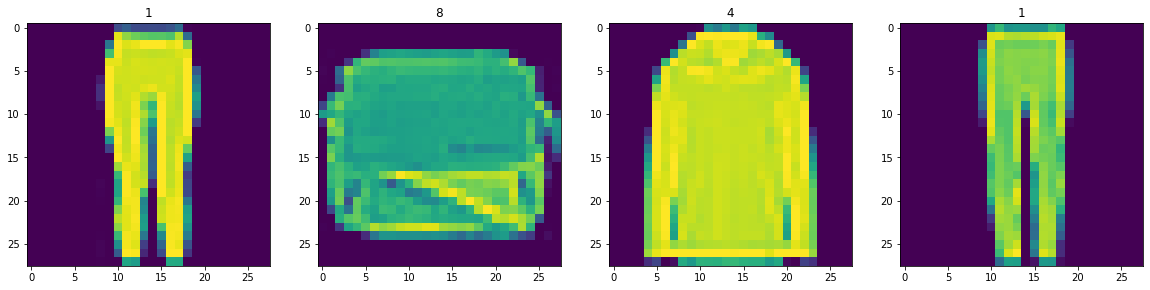

In [130]:
### Build dataset

# Setup connection aka iterator
dataiterator = ds.as_numpy_iterator()
# Getting data out of the pipeline
dataiterator.next()['image']
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx in range(4): 
    # Grab an image and label
    sample = dataiterator.next()
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(sample['image']))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(sample['label'])

In [131]:
# Scale and return images only 
def scale_images(data): 
    image = data['image']
    return image / 255

In [132]:
# Reload the dataset 
ds = tfds.load('fashion_mnist', split='train')
# Running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images) 
# Cache the dataset for that batch 
ds = ds.cache()
# Shuffle it up 
ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(128)
# Reduces the likelihood of bottlenecking 
ds = ds.prefetch(64)
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

In [133]:
### Build Generator
def build_generator(): 
    model = Sequential()
    
    # Takes in random values and reshapes it to 7x7x128
    # Beginnings of a generated image
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))
    
    # Upsampling block 1 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Upsampling block 2 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
    
    return model
generator = build_generator()


In [134]:
generator.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_36 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_4 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_8 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_36 (Conv2D)          (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_37 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                      

In [135]:
# Generate new fashion
img = generator.predict(np.random.randn(4,128,1))

img.shape

(4, 28, 28, 1)

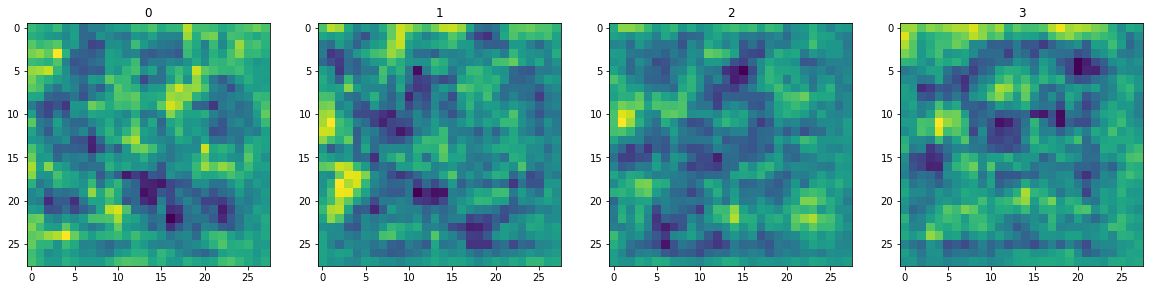

In [136]:
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx, img in enumerate(img): 
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(img))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(idx)

In [137]:
### Build Discriminator
def build_discriminator(): 
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model 
discriminator = build_discriminator()

In [138]:
discriminator.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_41 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_41 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_20 (Dropout)        (None, 24, 24, 32)        0         
                                                                 
 conv2d_42 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_42 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_21 (Dropout)        (None, 20, 20, 64)        0         
                                                                 
 conv2d_43 (Conv2D)          (None, 16, 16, 128)      

In [140]:
img = generator.predict(np.random.randn(4,128,1))

img.shape

(4, 28, 28, 1)

In [141]:
discriminator.predict(img)

array([[0.5089538 ],
       [0.5086496 ],
       [0.50872654],
       [0.5089294 ]], dtype=float32)

In [142]:
### Setup Losses and Optimizers
g_opt = Adam(learning_rate=0.0001) 
d_opt = Adam(learning_rate=0.00001) 
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()


In [143]:
class FashionGAN(Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class 
        super().__init__(*args, **kwargs)
        
        # Create attributes for gen and disc
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):
        # Get the data 
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape: 
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss - BINARYCROSS 
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # Apply backpropagation - nn learn 
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator 
        with tf.GradientTape() as g_tape: 
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
                                        
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

# Create instance of subclassed model
fashgan = FashionGAN(generator, discriminator)
# Compile the model
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

In [146]:
###Build Callback

class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('/content/images', f'generated_img_{epoch}_{i}.png'))

In [147]:
### train

hist = fashgan.fit(ds, epochs=20, callbacks=[ModelMonitor()])

Epoch 1/20
  6/469 [..............................] - ETA: 1:14 - d_loss: 0.4553 - g_loss: 0.7943WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0767s vs `on_train_batch_end` time: 0.0866s). Check your callbacks.


469/469 [==============================] - 74s 158ms/step - d_loss: 0.3378 - g_loss: 4.6258
Epoch 2/20
469/469 [==============================] - 74s 158ms/step - d_loss: 0.2849 - g_loss: 5.1629
Epoch 3/20
469/469 [==============================] - 74s 157ms/step - d_loss: 0.2754 - g_loss: 2.6404
Epoch 4/20
469/469 [==============================] - 74s 157ms/step - d_loss: 0.2737 - g_loss: 2.6764
Epoch 5/20
469/469 [==============================] - 73s 155ms/step - d_loss: 0.2728 - g_loss: 2.6882
Epoch 6/20
469/469 [==============================] - 74s 157ms/step - d_loss: 0.2858 - g_loss: 2.6462
Epoch 7/20
469/469 [==============================] - 74s 157ms/step - d_loss: 0.6173 - g_loss: 0.7692
Epoch 8/20
469/469 [==============================] - 74s 158ms/step - d_loss: 0.4426 - g_loss: 0.2274
Epoch 9/20
469/469 [==============================] - 74s 157ms/step - d_loss: 0.5589 - g_loss: 0.1790
Epoch 10/20
469/469 [==============================] - 73s 156ms/step - d_loss: 0.68

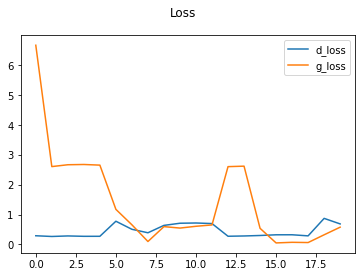

In [148]:
### performance

plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

In [158]:
### Generate Images

# generator.load_weights(os.path.join('/content/archive', 'generatormodel.h5'))
# imgs = generator.predict(tf.random.normal((16, 128, 1)))
# fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
# for r in range(4): 
#     for c in range(4): 
#         ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

In [154]:
generator.save('/content/generator.h5')
discriminator.save('/content/discriminator.h5')